# Module 7 Lab 2 - Clustering with DBSCAN
In the last lab we looked at kmeans clustering, and recognized a weakness as being blind to the distribution of the data.  We will take a look at DBSCAN, another approach for building clusters in the data.  DBSCAN does not require specifying the number of clusters in advance.  Instead, we specify some distance thresholds in order to get the minimum number of clusters that adhere to the "closeness" of the data.

DBSCAN has been used in in public health applications, as in the identification of hot spot regions of Dengue fever outbreaks:

[Dengue Fever in Perspective of Clustering Algorithms](../resources/Dengue-Fever-in-Perspective-of-Clustering-Algorithms.pdf)

In this lab we will use the diabetes dataset again.


In [1]:
from sklearn import datasets as d
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

b = d.load_diabetes()

data = pd.DataFrame(b.data, columns = b.feature_names)
data.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


## DBSCAN parameters
There are three parameters that must be set for [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html):

* eps (epsilon) - this is the maximum distance between two points for those points to be considered neighbors
* metric - the metric used to calculate the distance.  The default is `euclidean`, which we will use.
* min_samples - the minimum number of samples needed before a cluster can be formed

You can adjust these parameters as needed to suit the clustering outcome you want.  Modifying these parameters is the only way to have some control over the number of clusters.  We will use predetermined values for this lab to illustrate the concepts.

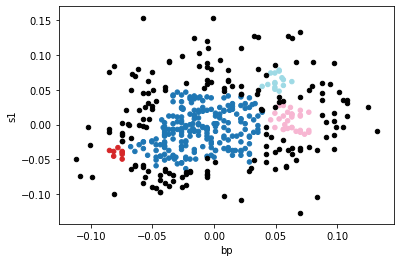

In [2]:
from sklearn.cluster import DBSCAN

subset=data.iloc[:, 3:5].copy()

model = DBSCAN(eps=0.012, min_samples=10).fit(subset)

clusters = model.labels_

cluster_mask = [True if x >= 0 else False for x in clusters]
ax1 = subset[cluster_mask].plot.scatter(x=0, y=1, c = clusters[clusters >= 0], colormap='tab20', colorbar = False)
subset[np.logical_not(cluster_mask)].plot.scatter(ax=ax1, x=0, y=1, c = 'black')
plt.show()

This may be familiar to you from the use of DBSCAN for identifying outliers.  Unlike KMeans, we don't get arbitrary groupings in our data.  We do however, have quite a bit of data that is not included in any cluster (the cluster value is `-1`).  Further analysis by a subject matter expert can be done to determine if this is beneficial or not by looking at the data continaed in the clusters and data not within the clusters.

Furthermore, because the DBSCAN model cannot be "trained", we cannot use the model to predict new data.  To include new data in the cluster definitions requires the model to be refitted, which could change how prior data was clustered.  However, DBSCAN is a good choice for clustering data for visual purposes, and as a data analysis method.

DBSCAN can be used to bootstrap a supervised learning model by helping with class identification and assignment, if the data form reasonable clusters that make clinical sense.  Also, it is a useful algorithm for outlier detection.

## Finding a good starting value for EPS
If you need to find a value for EPS, the maximum distance for two points to be considered neighbors, you might wonder how.  The value of EPS is dependent on the data, and when using euclidean distance measures, it's the geometric distance between the points.  

One way to find a good starting point in the search for EPS is to plot the results of the distance from each point to it's nearest neighbors, and see where that starts to dramatically increase.  This method is covered in [this](../resources/Determination-of-Optimal-Epsilon-Value-on-DBSCAN-Algorithm.pdf) paper.

We can use scikit learn's [NearestNeighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html) class for this.

We get the distances for each point to it's nearest neighbors, sort and plot the results.  The `metric` parameter's value should match the distance metric you plan to use in your clustering.  We use the euclidean distance metric below because DBSCAN defaults to euclidean, which is what we used above.  We then look across the y axis to find the approximate value at which the curve begins to steepen.

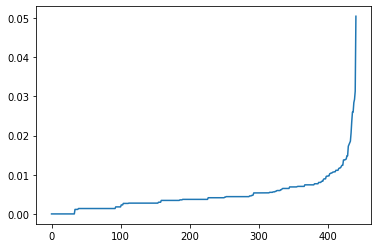

In [3]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=10, metric='euclidean')

neighbors = nn.fit(subset)

distances, _ = neighbors.kneighbors(subset)

distances = np.sort(distances, axis=0)

plt.plot(distances[:,1])


From this chart we can see the approximate value is around 0.01, which is close to the value we used above.

## Select min_samples
`min_samples` controls whether outlier data can be grouped into a cluster, and possibly absorbed into a nearby cluster.  This value should be set to optimize the number and size of clusters you get from DBSCAN, in conjunction with EPS.  The optimal clusters is problem specific and requires you to understand the makeup of your clusters and your goal for clustering, such as what we did at the end of lab 1.

## Clustering performance evaluation
The unlabeled methods for evaluating cluster performance, such as the [Silhouette Coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score) we looked at for KMeans, are typically not a good fit for DBSCAN clusters because they perform poorly on non convex clusters.

In this lab, we will look at the [Calinski-Harabaz Index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabaz_score.html#sklearn.metrics.calinski_harabaz_score).  This metric is a ratio of the between-clusters dispersion mean and within cluster dispersion.  Unlike the Silhouette Coefficient, this metric is not upper bounded, making it difficult to interpret.  Higher numbers mean better clusters, but these numbers can only be compared when clustering on the same data using either different clustering methods or different number of clusters.  

With DBSCAN, we have some data that is not clustered (the cluster number is `-1`.)  We must remove the unclustered data prior to computing the Calinski-Harabasz score, as it is not designed to be calculated on unclustered data points.  We will use the mask computed above when we plotted the data to now remove the non clustered data.

Note that you cannot calculate the score if your DBSCAN produced only one cluster, because Calinski Harabaz relies on between cluster measures which isn't possible if there is only one cluster.

In [4]:
from sklearn import metrics

subset['cluster'] = model.labels_

clustered_data = subset[cluster_mask]

print(round(metrics.calinski_harabaz_score(clustered_data.iloc[:,:-1], clustered_data.iloc[:,-1:].values.ravel()), 3))

93.387


The number by itself is meaningless.  We must compare to the same data set clustered by a different methodology.  We could rerun DBSCAN with different values for epsilon and min_samples and compare the scores.  Instead we will turn to lab 3 and try a different clustering method.